In [1]:
import tensorflow as tf
import tensorflow.keras as K
import random
from itertools import islice
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import TensorBoard

In [2]:
path_to_exps = 'DataForPython\\N_256\\diff_eq\\'
names = sorted(os.listdir(path_to_exps))
print(names)
print(len(names)//2)

['c_1.txt', 'c_2.txt', 'c_3.txt', 'c_4.txt', 'c_5.txt', 'temp_1.txt', 'temp_2.txt', 'temp_3.txt', 'temp_4.txt', 'temp_5.txt']
5


In [3]:
list_of_pairs = []
for i in range(len(names)//2):
        path_n = path_to_exps+names[i+len(names)//2]
        path_mu = path_to_exps+names[i]
        print(path_n, path_mu)
        list_of_pairs.append([path_n,path_mu])

DataForPython\N_256\diff_eq\temp_1.txt DataForPython\N_256\diff_eq\c_1.txt
DataForPython\N_256\diff_eq\temp_2.txt DataForPython\N_256\diff_eq\c_2.txt
DataForPython\N_256\diff_eq\temp_3.txt DataForPython\N_256\diff_eq\c_3.txt
DataForPython\N_256\diff_eq\temp_4.txt DataForPython\N_256\diff_eq\c_4.txt
DataForPython\N_256\diff_eq\temp_5.txt DataForPython\N_256\diff_eq\c_5.txt


In [4]:
def prepareData(path_n, path_mu):
        
        n_data = np.loadtxt(path_n)
        mu_data = np.loadtxt(path_mu)
        data = np.empty((1000, 256, 2))
        data[:,:,0] = n_data
        data[:,:,1] = mu_data
        
        exps_data.append(data) # exps_data[n_exp][time][space][n/mu]

In [5]:
exps_data = [] # Заполняю exps_data экспериментами
for i,j in list_of_pairs:
    print(i, j)
    prepareData(i,j)

DataForPython\N_256\diff_eq\temp_1.txt DataForPython\N_256\diff_eq\c_1.txt
DataForPython\N_256\diff_eq\temp_2.txt DataForPython\N_256\diff_eq\c_2.txt
DataForPython\N_256\diff_eq\temp_3.txt DataForPython\N_256\diff_eq\c_3.txt
DataForPython\N_256\diff_eq\temp_4.txt DataForPython\N_256\diff_eq\c_4.txt
DataForPython\N_256\diff_eq\temp_5.txt DataForPython\N_256\diff_eq\c_5.txt


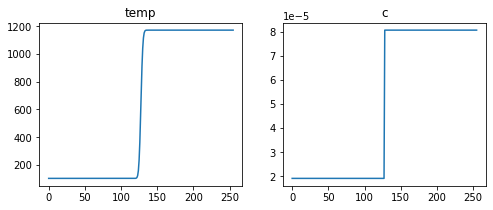

In [6]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1) # одна строчка, шесть столбцов, текущая ячейка первая 
plt.plot(np.asarray(exps_data)[0,0,:,0])
plt.title('temp')
plt.subplot(1, 2, 2)     
plt.plot(np.asarray(exps_data)[0,0,:,1])
plt.title('c')
plt.show()

In [7]:
dt = 1
H = 256
W = 256
data_index = []

for i, exp_m in enumerate(exps_data):
    exp_m_len = len(exp_m)
    data_index.extend(
        {
            'm_index' : i,
            'input_start' : j,
            'label_start' : j + dt
        }
        for j in range (exp_m_len - H - dt)
    )

In [8]:
def myMinMaxScaler(data): #data.shape = (5, 1000, 256, 2)
    T_min = 100.0
    T_max = 2000.0
    c_min = pow(10, -10)
    c_max = pow(10, -3)
    for i in range(len(data)):
        for j in range(len(data[i])):
            for k in range(len(data[i][j])):
                data[i][j][k][0] = (data[i][j][k][0] - T_min) / (T_max - T_min)
                data[i][j][k][1] = (data[i][j][k][1] - c_min) / (c_max - c_min)
    return data

In [9]:
# scale data to range (0,1)
exps_data = myMinMaxScaler(exps_data)

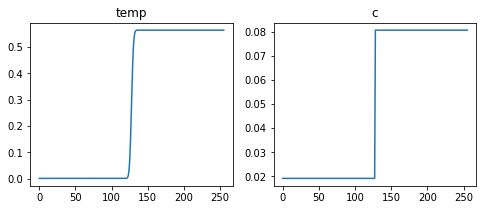

In [10]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1) # одна строчка, шесть столбцов, текущая ячейка первая 
plt.plot(np.asarray(exps_data)[0,0,:,0])
plt.title('temp')
plt.subplot(1, 2, 2)     
plt.plot(np.asarray(exps_data)[0,0,:,1])
plt.title('c')
plt.show()

In [11]:
def generator(exps_data, data_index, size):
    data_idx = data_index.copy()
    random.shuffle(data_idx)
    count = 0
    input_data = []
    label_data = []
    for ind in data_idx:
        M = exps_data[ind['m_index']]
        input_start = ind['input_start']
        label_start = ind['label_start']
        inp = M[input_start : input_start + H]
        lb = M[label_start : label_start + H]
        # print(M.shape) #(1000, 256, 2)
        # print(inp.shape) # (256, 256, 2)
        input_data.append(inp)
        label_data.append(lb)
                        
        count += 1
        if count % size == 0:
            yield np.array(input_data,np.float32), np.array(label_data,np.float32)
            input_data = []
            label_data = []
            

In [12]:
def train_generator(exps_data, data_index, batch_size, epochs):
    for _ in range(epochs):
        data_generator = generator(exps_data, data_index, batch_size)
        yield from data_generator

In [13]:
for input_data, label_data in generator(exps_data, data_index, 5):
    print(np.asarray(input_data).shape)  
    break

(5, 256, 256, 2)


(1, 256, 256, 2)
(1, 256, 256, 2)


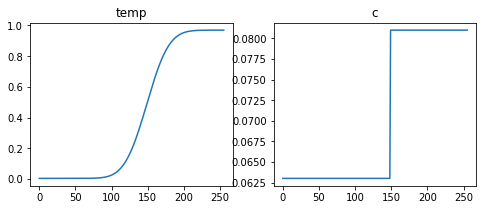

(1, 256, 256, 2)
(1, 256, 256, 2)


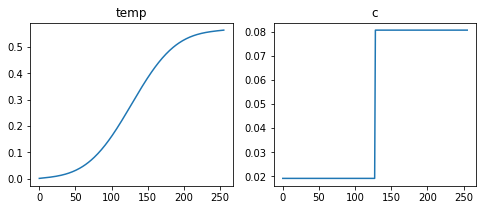

In [14]:
data_generator = generator(exps_data, data_index, 1)
for input_data, label_data in islice(data_generator, 2):
    print(input_data.shape)
    print(label_data.shape)
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1) # одна строка, два столбца, текущая ячейка первая    
    plt.plot(input_data[0, 50, :, 0])
    plt.title('temp')
    plt.subplot(1, 2, 2)     
    plt.plot(label_data[0, 50, :, 1])
    plt.title('c')
    plt.show()

In [15]:
# splitting at train and validation data
def train_val_data_splitting(data_index, size):
    data_idx = data_index.copy()
    random.shuffle(data_idx)
    val_data_index = data_idx[:len_val_data]
    train_data_index = data_idx[len_val_data:]
    return train_data_index, val_data_index

In [16]:
len_val_data = 15
train_data_index, val_data_index = train_val_data_splitting(data_index, len_val_data)
print(len(val_data_index), len(train_data_index), len(data_index))

15 3700 3715


In [17]:
def unet(input_shape):
    inp = K.Input(input_shape)
    
    conv1 = K.layers.Conv2D(64,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(inp)
    conv1 = K.layers.Conv2D(64,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = K.layers.MaxPool2D(pool_size=(2, 2))(conv1)
    
    conv2 = K.layers.Conv2D(128,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = K.layers.Conv2D(128,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = K.layers.MaxPool2D(pool_size=(2, 2))(conv2)
    
    conv3 = K.layers.Conv2D(256,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = K.layers.Conv2D(256,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = K.layers.MaxPool2D(pool_size=(2, 2))(conv3)
    
    conv4 = K.layers.Conv2D(512,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = K.layers.Conv2D(512,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = K.layers.MaxPool2D(pool_size=(2, 2))(conv4)
    
    conv5 = K.layers.Conv2D(1024,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = K.layers.Conv2D(1024,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv5)

    upconv6 = K.layers.UpSampling2D(size=(2,2))(conv5)
    data_concat = K.layers.concatenate([upconv6, conv4], axis = 3)
    conv6 = K.layers.Conv2D(512,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(data_concat)
    conv6 = K.layers.Conv2D(512,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv6)
    
    upconv7 = K.layers.UpSampling2D(size=(2,2))(conv6)
    data_concat = K.layers.concatenate([upconv7, conv3], axis = 3)
    conv7 = K.layers.Conv2D(256,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(data_concat)
    conv7 = K.layers.Conv2D(256,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv7)
    
    upconv8 = K.layers.UpSampling2D(size=(2,2))(conv7)
    data_concat = K.layers.concatenate([upconv8, conv2], axis = 3)
    conv8 = K.layers.Conv2D(128,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(data_concat)
    conv8 = K.layers.Conv2D(128,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv8)
    
    upconv9 = K.layers.UpSampling2D(size=(2,2))(conv8)
    data_concat = K.layers.concatenate([upconv9, conv1], axis = 3)
    conv9 = K.layers.Conv2D(64,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(data_concat)
    conv9 = K.layers.Conv2D(64,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = K.layers.Conv2D(2, (1, 1),activation = None)(conv9) 
    
    model = K.Model(inp, conv10)
    
    return model

In [18]:
# 6 изображений: три пары (для n и mu), входные данные, их лэйблы, предсказание - в функцию validate
def validate(val_mode, data, data_index):
    random.seed(5)
    
    validation_data_generator = generator(data, data_index, 1)
    time = 255
    for batch_inputs, batch_labels in validation_data_generator:
        # print(np.asarray(batch_inputs).shape) 
        # print(np.asarray(batch_labels).shape) 
        # break
        model_output = val_mode.predict_on_batch(batch_inputs)
        plt.figure(figsize=(20, 3))
        plt.subplot(1, 6, 1) # одна строчка, шесть столбцов, текущая ячейка первая
        plt.plot(batch_inputs[0,time,:,0])
        plt.title('Input temp')
        
        plt.subplot(1, 6, 2) 
        plt.plot(batch_inputs[0,time,:,1])
        plt.title('Input c')
        
        plt.subplot(1, 6, 3) 
        plt.plot(batch_labels[0,time,:,0])
        plt.title('Label (t + delta_t) temp')
        
        plt.subplot(1, 6, 4) 
        plt.plot(batch_labels[0,time,:,1])
        plt.title('Label (t + delta_t) c')
        
        plt.subplot(1, 6, 5) 
        plt.plot(model_output[0,time,:,0])
        plt.title('Prediction temp')
        
        plt.subplot(1, 6, 6)
        plt.plot(model_output[0,time,:,1])
        plt.title('Prediction c')
        plt.show()

In [19]:
K.backend.clear_session()
model = unet([256, 256, 2])
model.compile(optimizer = K.optimizers.Adam(learning_rate=1e-4), loss='mse')
# model.summary()

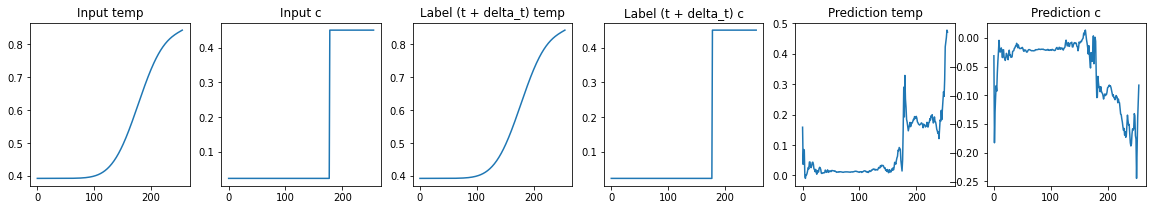

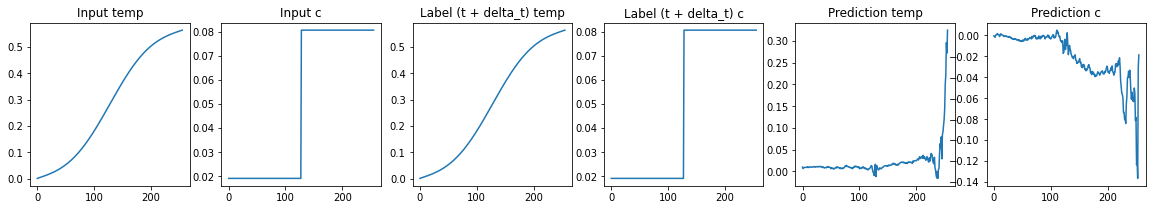

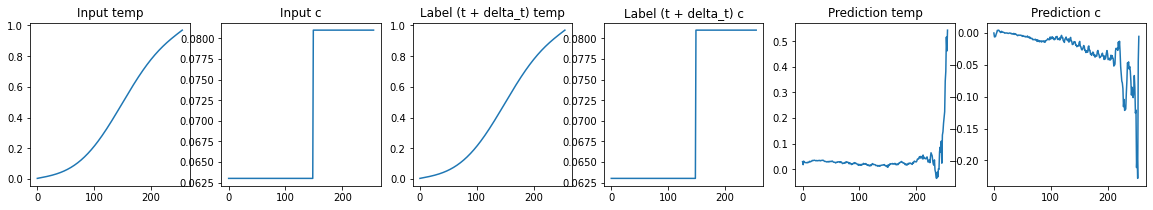

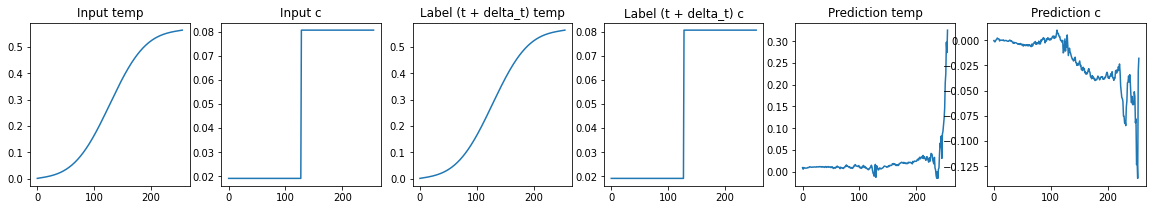

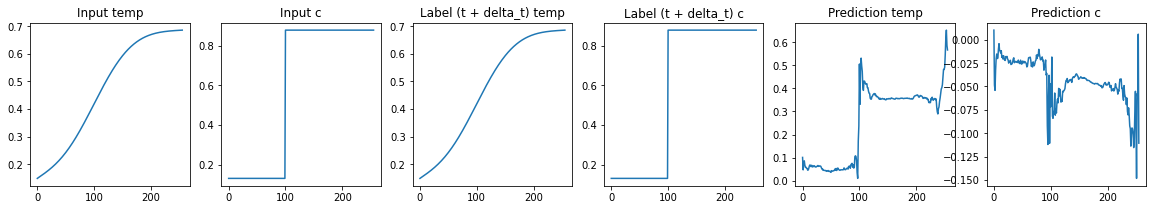

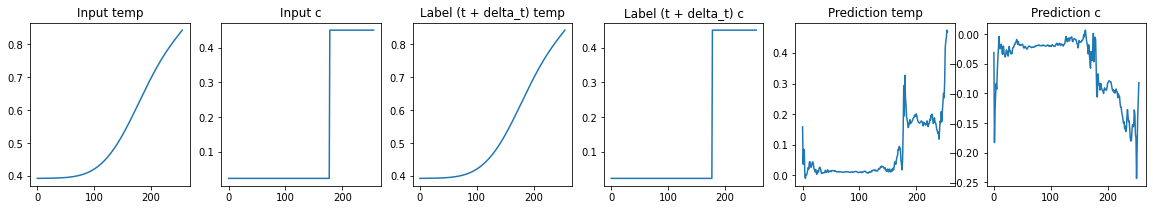

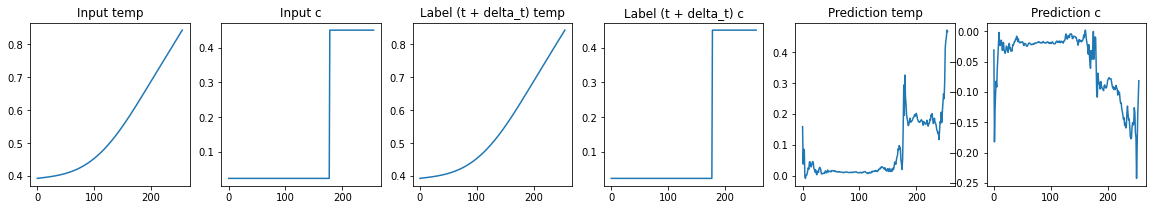

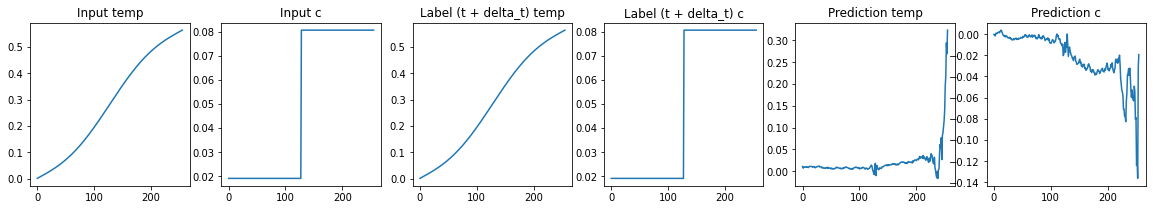

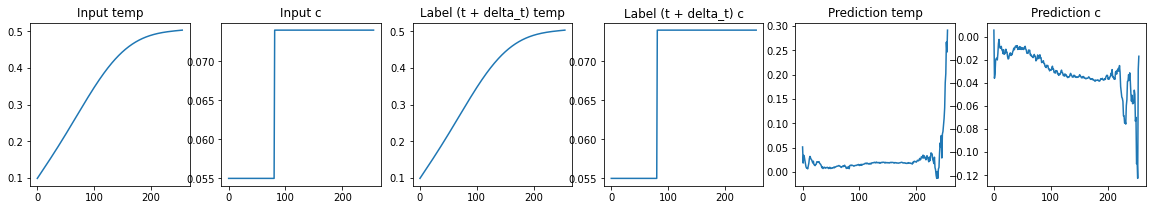

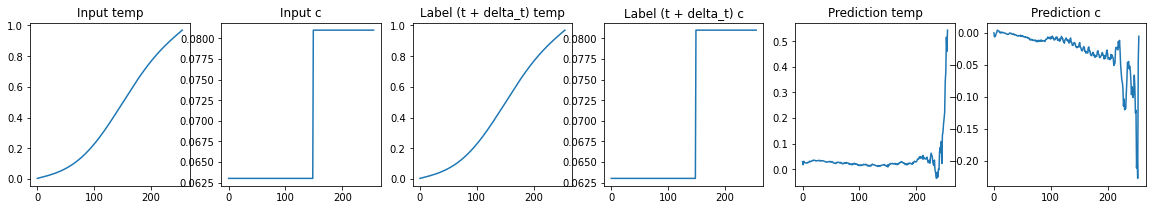

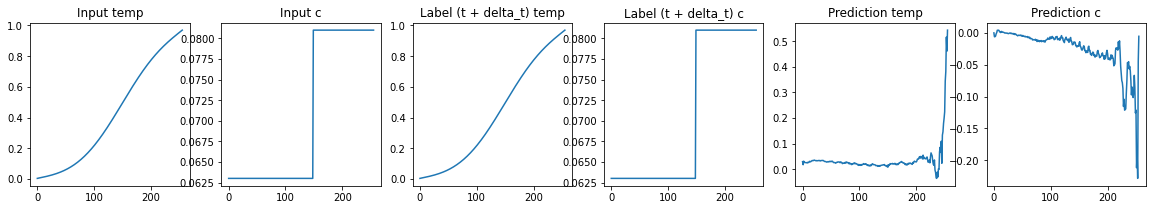

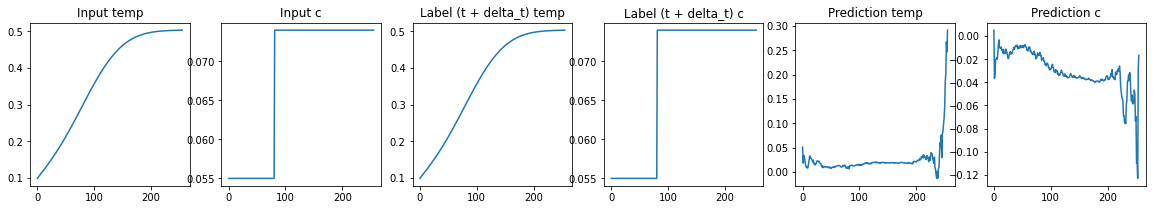

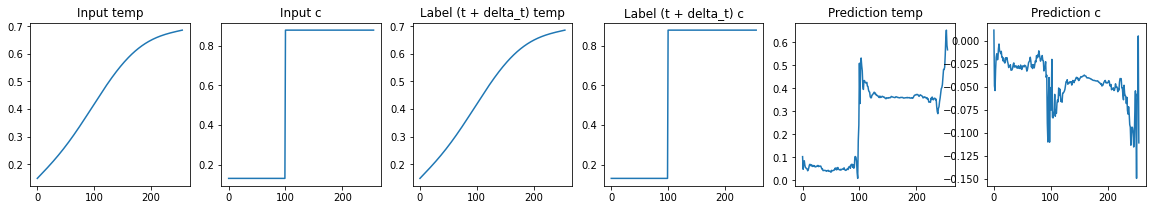

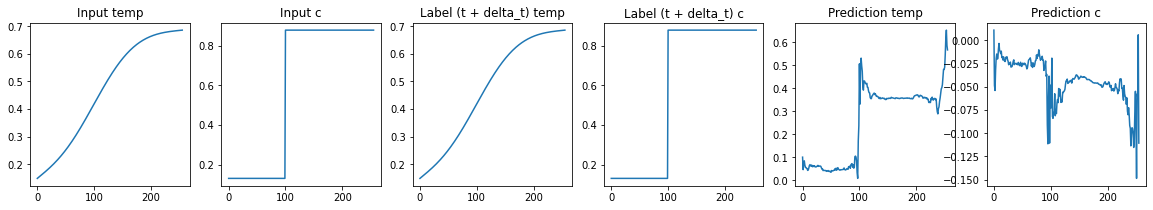

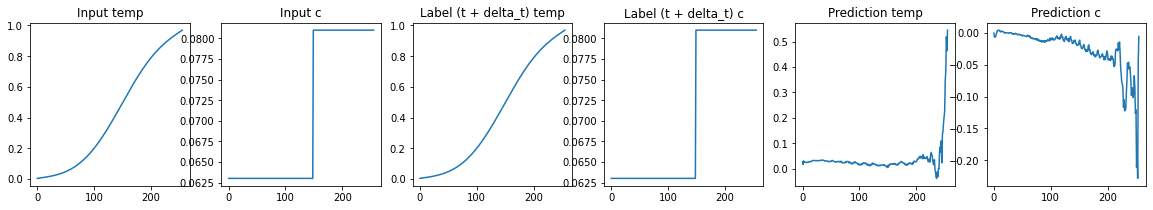

In [23]:
validate(model, exps_data, val_data_index)

In [24]:
batch_size = 4
epochs = 3
steps_per_epoch = len(train_data_index) // batch_size 
train_data_generator = train_generator(exps_data, train_data_index, batch_size, epochs)
history = model.fit(train_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs) 

Epoch 1/3
 27/925 [..............................] - ETA: 4:01:21 - loss: 0.0745

KeyboardInterrupt: 

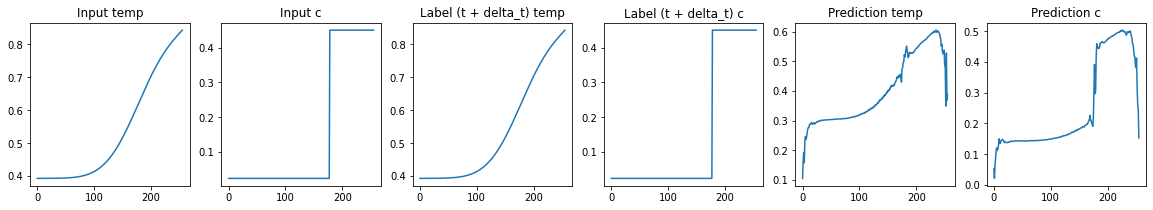

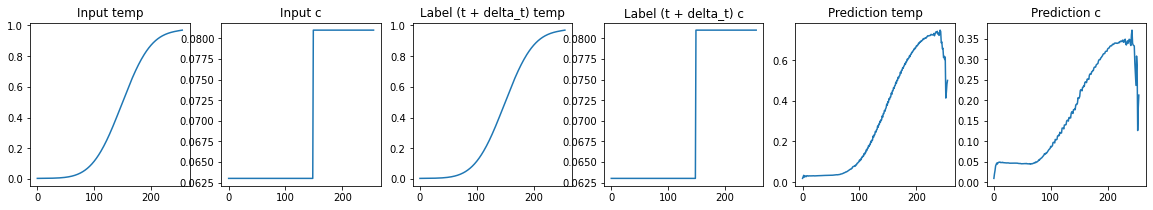

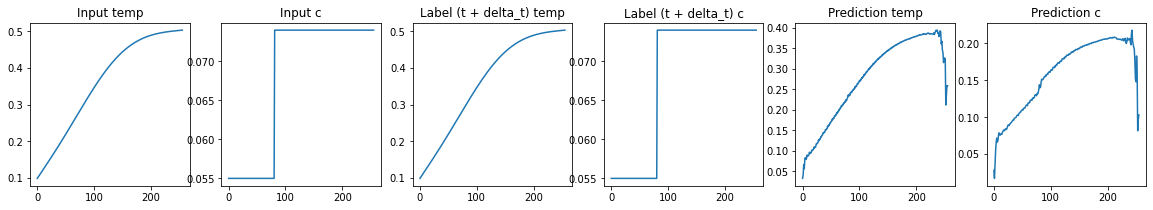

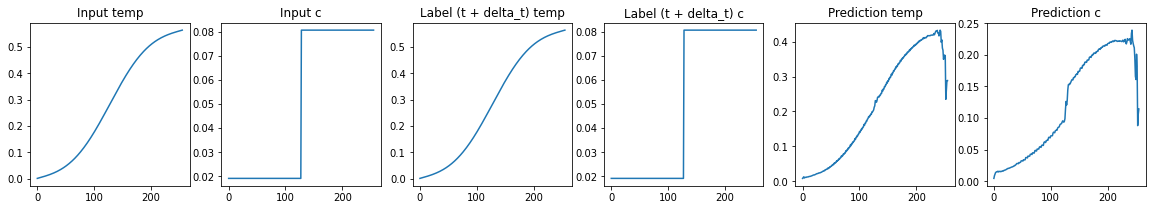

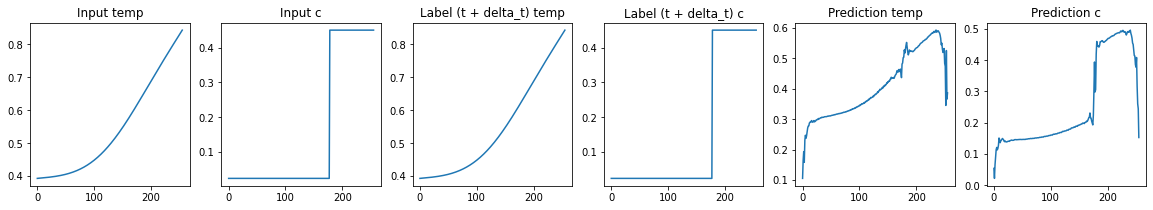

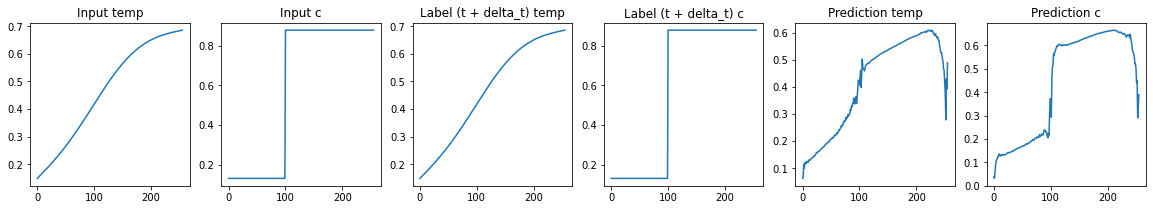

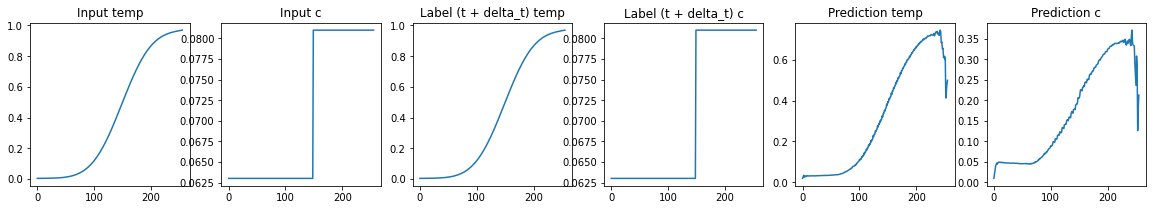

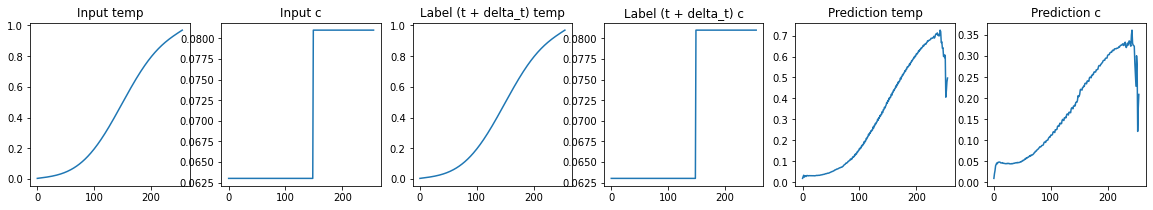

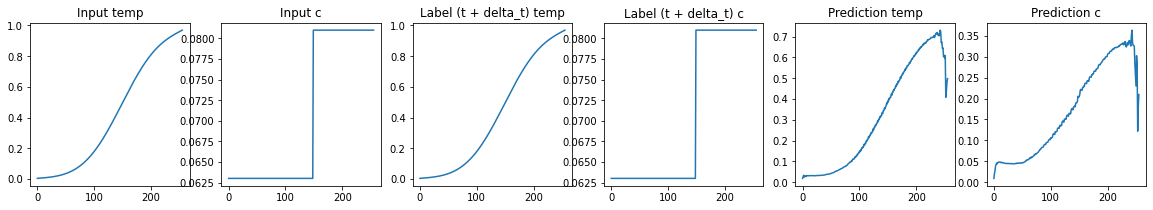

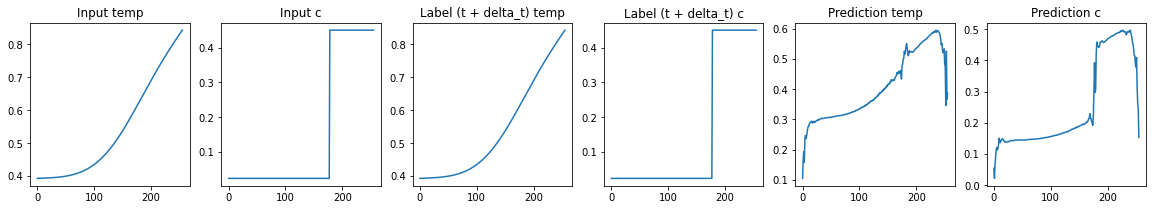

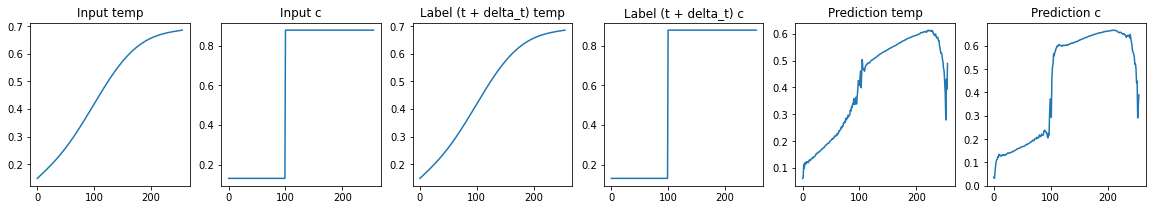

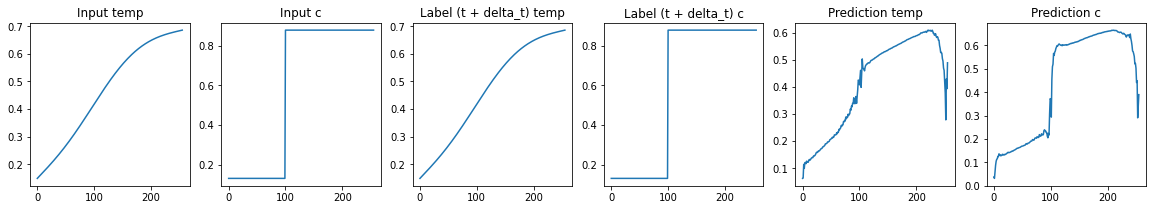

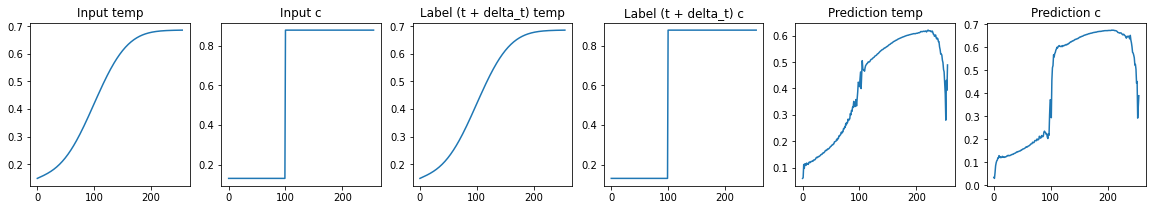

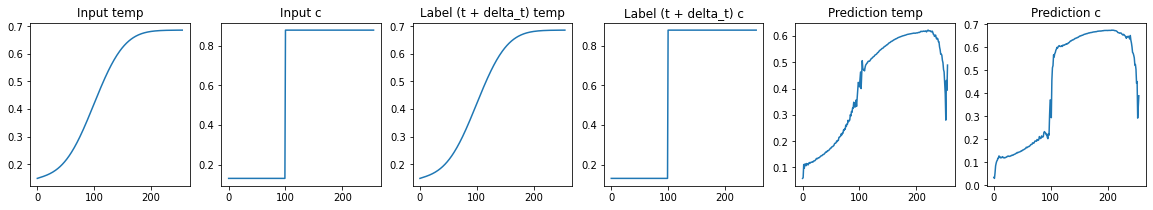

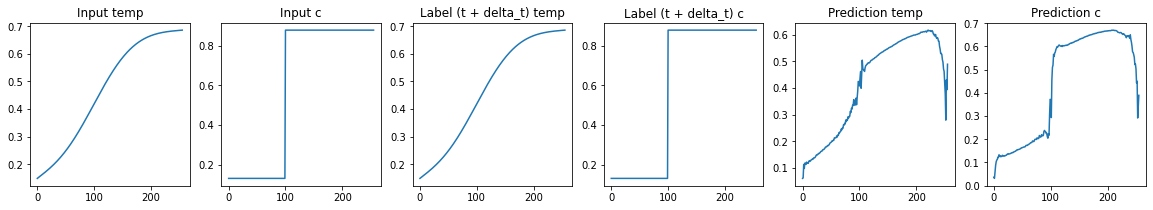

In [25]:
validate(model, exps_data, val_data_index)

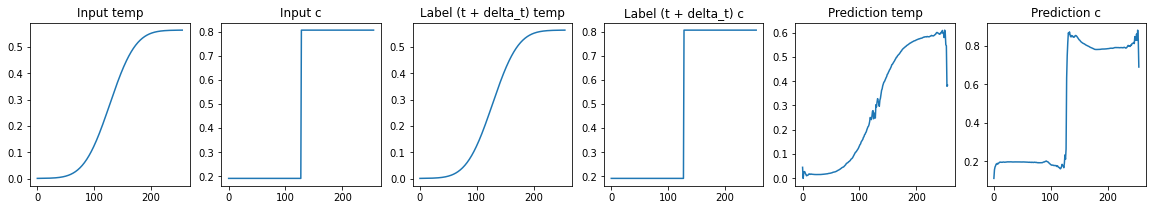

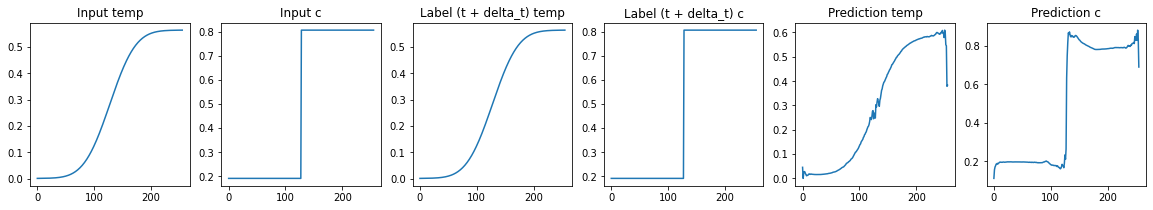

In [219]:
epochs = 10

# Стартуем с предыдущей эпохи (особенно важно, если у вас как то зависят параметры оптимизатора от номера эпохи)
# Также должна правильно обновляться история и производиться логнирование в TensorBoard
prev_epoch = history.epoch[-1] + 1

history = model.fit(train_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs + prev_epoch,  # prev_epoch уже пройдено, и ещё новых epochs
                    initial_epoch=prev_epoch) # непосредственно указание, что prev_epoch пройдено

In [ ]:
validate(model, exps_data, data_index)

## Аугментация: 
#  Из тех, что были представлены в уроке
    Отражение +, 
    Поворот -, так как может перестать удовлетворять нормировке (вылезет за 0 или 1),
    Размытие, смотря что под ним подразумевать,
    Вырез -, только если использовать интерполяцию, так как размер изменится
# Прочие  
    добавление шума\случайных выбросов, 